# Diploma thesis
## Breast cancer classification using machine learning methods
### Feature Selection & Data Visualization

> Lazaros Panitsidis<br />
> Department of Production and Management Engineering <br />
> International Hellenic University <br />
> lazarospanitsidis@outlook.com

![support breast cancer](https://wallpaperaccess.com/full/1113806.png)

![breast cancer](https://techvidvan.com/tutorials/wp-content/uploads/sites/2/2021/08/breast-cancer-diagram.jpg)

## Contents
1. [Useful Python Libraries](#1)
1. [Data Content](#2)
1. [Data Analysis](#3)
1. [Visualization](#4)
1. [Feature Selection and Random Forest Classification](#5)
     1. [Feature Selection by Correlation](#6)
     1. [Univariate feature selection (SelectKbest)](#7)
     1. [Recursive Feature Elimination (RFE)](#8)
     1. [Recursive Feature Elimination with Cross-Validation (RFECV)](#9)
     1. [Feature importances with a forest of trees](#10)
     1. [XGBoost Feature Importances](#11)
     1. [Minimum Redundancy & Maximum Relevance](#12)
1. [Feature extraction with PCA](#11)
1. [Summary](#12)

<a id='1'></a>
## Useful Python Libraries

In [118]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE, RFECV , mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score , GridSearchCV , LeaveOneOut , KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score , make_scorer , classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.preprocessing import StandardScaler , LabelEncoder
from xgboost import XGBClassifier , plot_importance
from sklearn.utils import resample

<a id='2'></a>
## Data Content
1. **ID number**
1. **Diagnosis (M = malignant, B = benign)**
1. **radius (mean of distances from center to points on the perimeter)**
1. **texture (standard deviation of gray-scale values)**
1. **perimeter**
1. **area**
1. **smoothness (local variation in radius lengths)**
1. **compactness $(\frac{perimeter^2}{area-1})$**
1. **concavity (severity of concave portions of the contour)**
1. **concave points (number of concave portions of the contour)**
1. **symmetry**
1. **fractal dimension ("coastline approximation" - 1)**
<br>
* The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.
* All feature values are recoded with four significant digits.
* Missing attribute values: none
* Class distribution: 357 benign, 212 malignant


<a id='3'></a>
## Data Analysis

In [2]:
dataWISC = pd.read_csv('dataWisc.csv')
dataWISC

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


**There are 3 things observed in the dataframe :**
1) There is an **id** that cannot be used for classificaiton 
2) **Diagnosis** is the class label
3) **Unnamed: 32** feature includes NaN so it is useless.

In [3]:
dataWISC.drop(["id", "Unnamed: 32"], axis = 1, inplace = True)

* check for NaN values in the whole dataframe

In [4]:
dataWISC.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [5]:
#Description of the dataset

#how many cases are included in the dataset
length = len(dataWISC)
#how many features are in the dataset
features = dataWISC.shape[1]-1 # - diagnosis

# Number of malignant cases
malignant = len(dataWISC[dataWISC['diagnosis']=='M'])

#Number of benign cases
benign = len(dataWISC[dataWISC['diagnosis']=='B'])

#Rate of malignant tumors over all cases
rate = (float(malignant)/(length))*100

print ("There are "+ str(len(dataWISC))+" cases in this dataset")
print ("There are {}".format(features)+" features in this dataset")
print ("There are {}".format(malignant)+" cases diagnosed as malignant tumor")
print ("There are {}".format(benign)+" cases diagnosed as benign tumor")
print ("The percentage of malignant cases is: {:.2f}%".format(rate))

There are 569 cases in this dataset
There are 30 features in this dataset
There are 212 cases diagnosed as malignant tumor
There are 357 cases diagnosed as benign tumor
The percentage of malignant cases is: 37.26%


Number of Benign:  357
Number of Malignant :  212


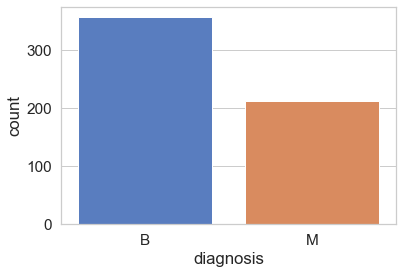

In [6]:
sns.set(style="whitegrid", palette="muted",font_scale = 1.4)
# f,ax = plt.subplots(figsize=(4, 4))
ax = sns.countplot(dataWISC['diagnosis'],label="Count",order=['B','M'])       # M = 212, B = 357
B, M = dataWISC['diagnosis'].value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

### [Undersampling](https://www.mastersindatascience.org/learning/statistics-data-science/undersampling/)

* Undersampling is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. It is one of several techniques data scientists can use to extract more accurate information from originally imbalanced datasets. Though it has disadvantages, such as the loss of potentially important information, it remains a common and important skill for data scientists. 

In [117]:
# *** Function for undersampling ***
def make_undersample(_df, column):
  dfs_r = {}
  dfs_c = {}
  smaller = 1e1000
  ignore = ""
  for c in _df[column].unique():
    dfs_c[c] = _df[_df[column] == c]
    if dfs_c[c].shape[0] < smaller:
      smaller = dfs_c[c].shape[0]
      ignore = c

  for c in dfs_c:
    if c == ignore:
      continue
    dfs_r[c] = resample(dfs_c[c], 
                        replace=False,
                        n_samples=smaller,
                        random_state=0)
  return pd.concat([dfs_r[c] for c in dfs_r] + [dfs_c[ignore]])

In [7]:
dataWISC = make_undersample(dataWISC,'diagnosis')

#Description of the dataset

#how many cases are included in the dataset
length = len(dataWISC)
#how many features are in the dataset
features = dataWISC.shape[1]-1 # - diagnosis

# Number of malignant cases
malignant = len(dataWISC[dataWISC['diagnosis']=='M'])

#Number of benign cases
benign = len(dataWISC[dataWISC['diagnosis']=='B'])

#Rate of malignant tumors over all cases
rate = (float(malignant)/(length))*100

print ("There are "+ str(len(dataWISC))+" cases in this dataset")
print ("There are {}".format(features)+" features in this dataset")
print ("There are {}".format(malignant)+" cases diagnosed as malignant tumor")
print ("There are {}".format(benign)+" cases diagnosed as benign tumor")
print ("The percentage of malignant cases is: {:.2f}%".format(rate))

There are 424 cases in this dataset
There are 30 features in this dataset
There are 212 cases diagnosed as malignant tumor
There are 212 cases diagnosed as benign tumor
The percentage of malignant cases is: 50.00%


* y includes diagnosis and x includes the characteristics

In [8]:
y = dataWISC.diagnosis                          # M or B 
x = dataWISC.drop('diagnosis',axis = 1 )
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
49,13.490,22.30,86.91,561.0,0.08752,0.07698,0.04751,0.033840,0.1809,0.05718,0.2338,1.3530,1.735,20.20,0.004455,0.013820,0.02095,0.011840,0.01641,0.001956,15.15,31.82,99.00,698.8,0.1162,0.17110,0.228200,0.128200,0.2871,0.06917
285,12.580,18.40,79.83,489.0,0.08393,0.04216,0.00186,0.002924,0.1697,0.05855,0.2719,1.3500,1.721,22.45,0.006383,0.008008,0.00186,0.002924,0.02571,0.002015,13.50,23.08,85.56,564.1,0.1038,0.06624,0.005579,0.008772,0.2505,0.06431
495,14.870,20.21,96.12,680.9,0.09587,0.08345,0.06824,0.049510,0.1487,0.05748,0.2323,1.6360,1.596,21.84,0.005415,0.013710,0.02153,0.011830,0.01959,0.001812,16.01,28.48,103.90,783.6,0.1216,0.13880,0.170000,0.101700,0.2369,0.06599
391,8.734,16.84,55.27,234.3,0.10390,0.07428,0.00000,0.000000,0.1985,0.07098,0.5169,2.0790,3.167,28.85,0.015820,0.019660,0.00000,0.000000,0.01865,0.006736,10.17,22.80,64.01,317.0,0.1460,0.13100,0.000000,0.000000,0.2445,0.08865
187,11.710,17.19,74.68,420.3,0.09774,0.06141,0.03809,0.032390,0.1516,0.06095,0.2451,0.7655,1.742,17.86,0.006905,0.008704,0.01978,0.011850,0.01897,0.001671,13.01,21.39,84.42,521.5,0.1323,0.10400,0.152100,0.109900,0.2572,0.07097


Number of Benign:  212
Number of Malignant :  212


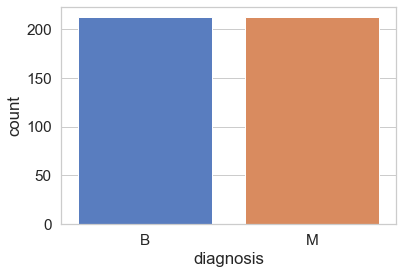

In [9]:
ax = sns.countplot(y,label="Count",order=['B','M'])       # M = 212, B = 212
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

* One does not need to know the meaning of these features, however should know values such as variance, standard deviation, number of samples (population) or max/min values. This kind of information helps to understand what is happening in the data.

In [10]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,14.813972,19.814316,96.749057,721.845755,0.096905,0.110630,0.101918,0.056033,0.183016,0.062478,0.447524,1.213228,3.164023,47.088752,0.006890,0.026468,0.033242,0.012246,0.020442,0.003836,17.271708,26.463844,114.225000,992.393868,0.133932,0.274730,0.304416,0.127011,0.296170,0.085116
std,3.710883,4.399382,25.624459,377.877236,0.013689,0.055373,0.084258,0.041416,0.027781,0.006955,0.304111,0.534103,2.222190,50.782881,0.002864,0.018117,0.027148,0.006033,0.008654,0.002540,5.105619,6.279056,35.519248,614.099977,0.023059,0.166932,0.217296,0.068830,0.066159,0.018959
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.026500,0.000000,0.000000,0.120300,0.049960,0.111500,0.362100,0.757000,6.802000,0.002667,0.003012,0.000000,0.000000,0.007882,0.000950,7.930000,12.020000,50.410000,185.200000,0.084090,0.043270,0.000000,0.000000,0.156500,0.055040
25%,12.092500,16.792500,78.062500,449.750000,0.087355,0.068045,0.034103,0.022690,0.163350,0.057427,0.243850,0.829700,1.733000,19.342500,0.005143,0.013945,0.016905,0.008080,0.014942,0.002272,13.340000,21.975000,87.157500,546.700000,0.117175,0.156825,0.137700,0.069823,0.252650,0.071903
50%,14.000000,19.625000,91.405000,601.400000,0.095865,0.102150,0.080945,0.044485,0.180800,0.061230,0.356500,1.082000,2.550000,29.085000,0.006254,0.022075,0.028095,0.011595,0.018520,0.003240,16.010000,26.120000,106.000000,784.150000,0.134200,0.231600,0.270700,0.118450,0.285450,0.081170
75%,17.367500,22.307500,114.250000,936.775000,0.106025,0.135600,0.152350,0.086260,0.197450,0.065835,0.562625,1.466250,3.838250,58.555000,0.008050,0.033247,0.043443,0.015395,0.023082,0.004562,20.585000,30.865000,137.950000,1302.500000,0.148225,0.362550,0.419150,0.182000,0.321850,0.093545
max,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,3.647000,21.980000,542.200000,0.031130,0.135400,0.303800,0.040900,0.078950,0.022860,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


* check for duplicated values

In [11]:
x.duplicated().sum()

0

<a id='4'></a>
## Visualization

In [12]:
# x.hist(figsize=(16, 20), bins=30, edgecolor="black") # simple plot without labels
# plt.subplots_adjust()

* From the graphs below, what is useful to notice is the separability of the probability density function between the values of benign and malignant cancer for each feature.

* This separability should be as high as possible so that the features provide good information for classification in the machine learning models that will be built afterwards.

In [13]:
# # https://github.com/bora-pajo/breast-cancer-prediction/blob/master/examples_save1.ipynb
# #to see how distribution is in regard to the diagnosis, we need to first split the dataset into two groups
# malignant = dataWISC[dataWISC['diagnosis'] =='M']
# benign = dataWISC[dataWISC['diagnosis'] =='B']

# #also bring features back, basically redefining them again
# features = list(dataWISC.columns[1:31])

# plt.rcParams.update({'font.size': 11})
# fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(13,15))
# axes = axes.ravel()
# for i,plot1 in enumerate(axes):
#     plot1.figure
#     binwidth= (max(dataWISC[features[i]]) - min(dataWISC[features[i]]))/30
#     plot1.hist([malignant[features[i]],benign[features[i]]], bins=np.arange(min(dataWISC[features[i]]), max(dataWISC[features[i]]) + binwidth, binwidth) , # density : If True, draw and return a probability density: each bin will display the bin's raw count divided by the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins))),
#                 alpha=0.5, density=True, stacked=True ,edgecolor="black",label=['Malignant','Benign'],color=['orangered','deepskyblue'])          # so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).If stacked is also True, the sum of the histograms is normalized to 1.
                
#     plot1.legend(loc='upper right')
#     plot1.set_title(features[i])
#     # plot1.grid()
# plt.tight_layout()
# plt.show()

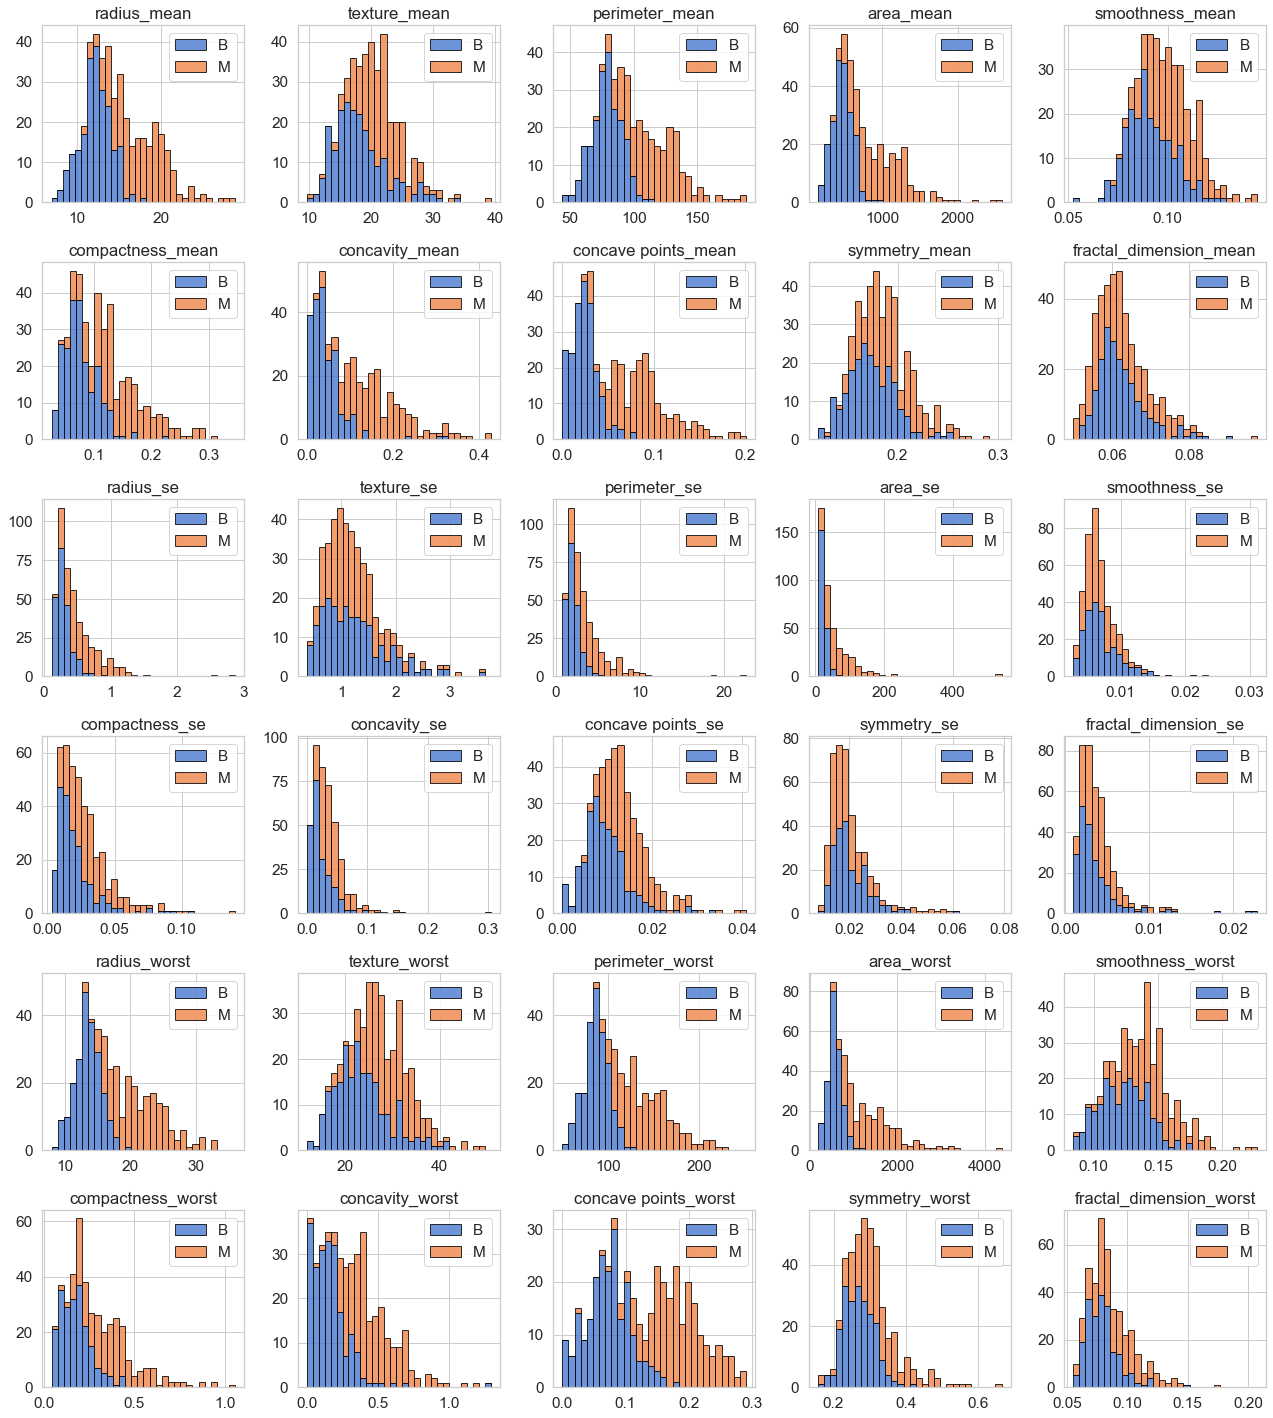

In [14]:
# https://github.com/bora-pajo/breast-cancer-prediction/blob/master/examples_save1.ipynb
#to see how distribution is in regard to the diagnosis, we need to first split the dataset into two groups
malignant = dataWISC[dataWISC['diagnosis'] =='M']
benign = dataWISC[dataWISC['diagnosis'] =='B']

#also bring features back, basically redefining them again
features = list(dataWISC.columns[1:31])
# sns.set(style="whitegrid",palette="muted",font_scale = 1.2)
# plt.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(18,20))
axes = axes.ravel()
for i,plot1 in enumerate(axes):
    plot1.figure
    binwidth= (max(dataWISC[features[i]]) - min(dataWISC[features[i]]))/30
    plot1.hist([benign[features[i]],malignant[features[i]]], bins=np.arange(min(dataWISC[features[i]]), max(dataWISC[features[i]]) + binwidth, binwidth) , # density : If True, draw and return a probability density: each bin will display the bin's raw count divided by the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins))),
                alpha=0.8, density=False, stacked=True ,edgecolor="black",label=['B','M'])          # so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).If stacked is also True, the sum of the histograms is normalized to 1.
                
    plot1.legend(loc='upper right')
    plot1.set_title(features[i])
    # plot1.grid()
plt.tight_layout()
plt.show()

* As can be seen from the figures above, malignant types appear to have higher values in most features compared to benign types. Malignant types are almost right skewed in most cases. By looking at this, an estimate can be made of which features are likely to be the most indicative of the types of cancer.

* It is observed (also shown at the describe method above) that features (dimensions) have very different distributions. Normalization is needed before the violin and swarm plots, because the differences between feature values ​​are too high to be seen in the plots.

* Some Machine Learning methods give better results if the data is *normalised*.

* There are several ways to normalize data:

  * Transform the data so that the values ​​of each column range in the interval $[0, 1]$.
  * Convert the data so that the values ​​of each column range in the interval $[-1, 1]$.
  * Transform the data so that the values ​​in each column have a mean of $0$ and a variance of $1$.

  
* All this (and more) can be done by `scikit-learn`.

* So will normalize the data to have mean $0$ and variance $1$, using a `StandardScaler`.

* This means that `StandardScaler` will learn, for each column, the mean $\mu$ and the variance $\sigma^2$.

* In practice `StandardScaler` performs for each element $x$ the operation:

   $$ x_{scaled} = \frac{x-\mu}{\sigma^2} $$
  
   where $\mu$ is the column mean and $\sigma^2$ is the column variance.

In [15]:
# x_scaled = (x - x.min(axis=0)) / (x.max(axis=0)-x.min(axis=0))              # min max scale

x_scaled = (x - x.mean())/x.std() # If we use StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled.hist(figsize=(16, 20), bins=30, edgecolor="black") # plot to show features after scaling
# plt.subplots_adjust()

* Seaborn will be used in order to visualize the data and show the diversity of the graphs.

* The features are drawn in 3 groups and each group includes 10 features to make them easier to observe.

<AxesSubplot:xlabel='value', ylabel='features'>

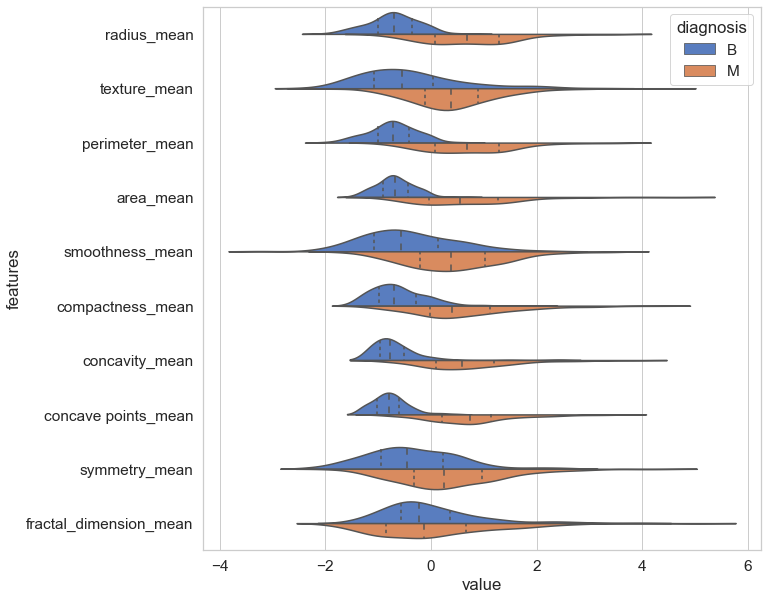

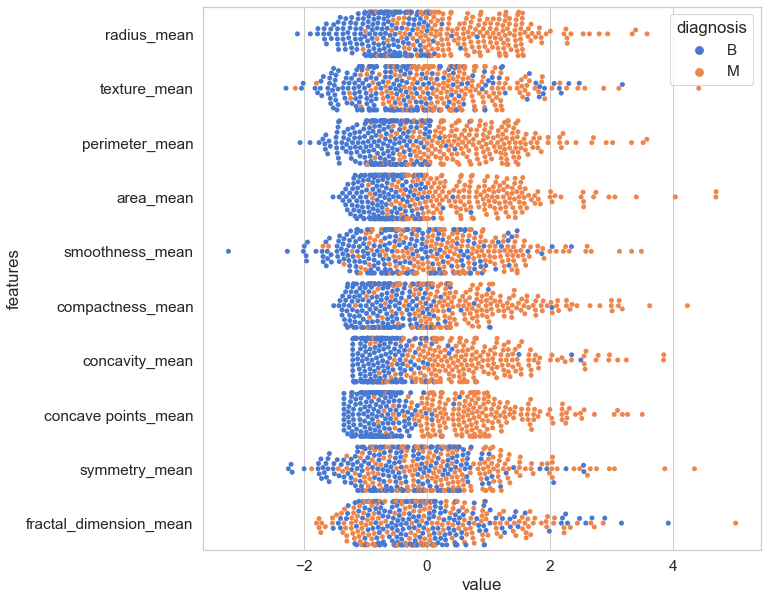

In [16]:
# https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization
# first ten features
# sns.set(style="whitegrid", palette="muted",font_scale = 1.2)
data = pd.concat([y,x_scaled.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="diagnosis", data=data,split=True, inner="quart")
# plt.xticks(rotation=90)

# sns.set(style="whitegrid", palette="muted")
data = pd.concat([y,x_scaled.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
tic = time.time()
sns.swarmplot(x="value", y="features", hue="diagnosis", data=data)

<AxesSubplot:xlabel='value', ylabel='features'>

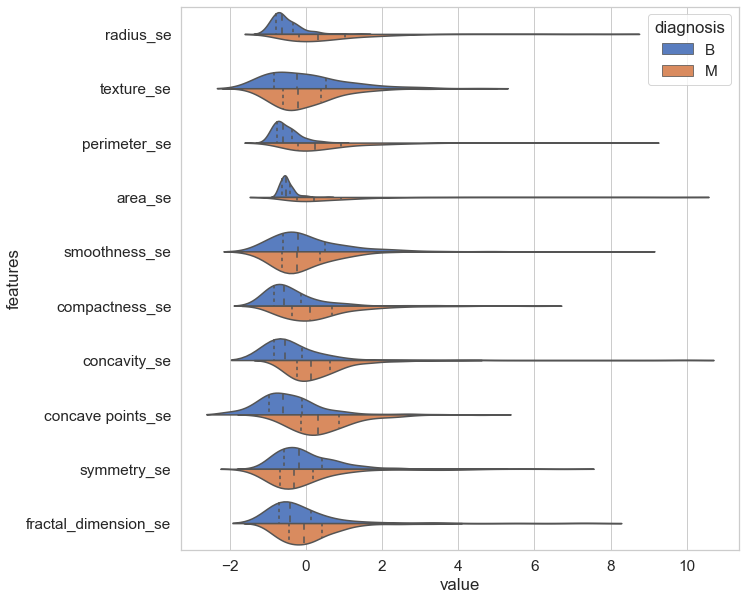

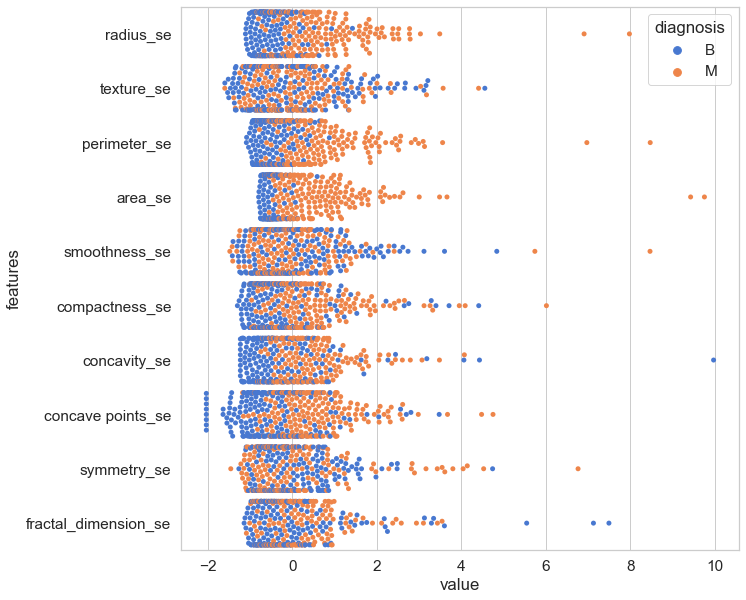

In [17]:
# Second ten features
data = pd.concat([y,x_scaled.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="diagnosis", data=data,split=True, inner="quart")
# plt.xticks(rotation=90)

data = pd.concat([y,x_scaled.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="value", y="features", hue="diagnosis", data=data)
# plt.xticks(rotation=90)

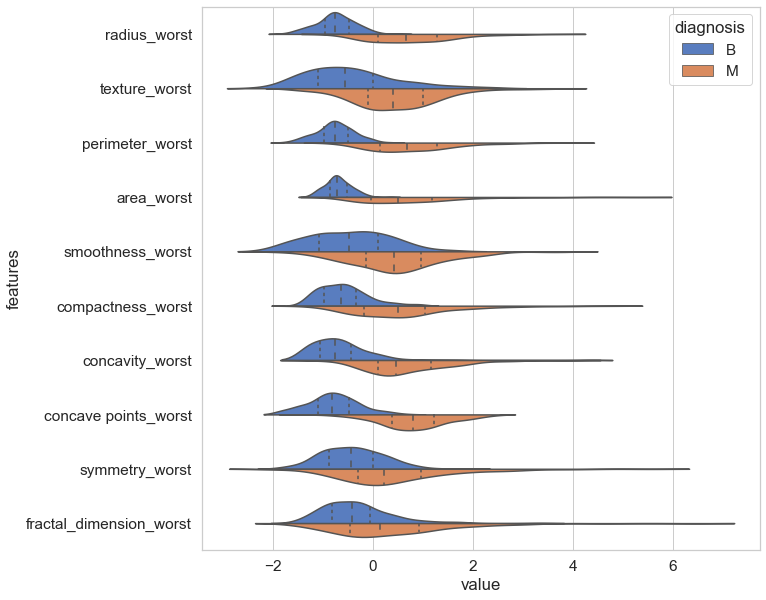

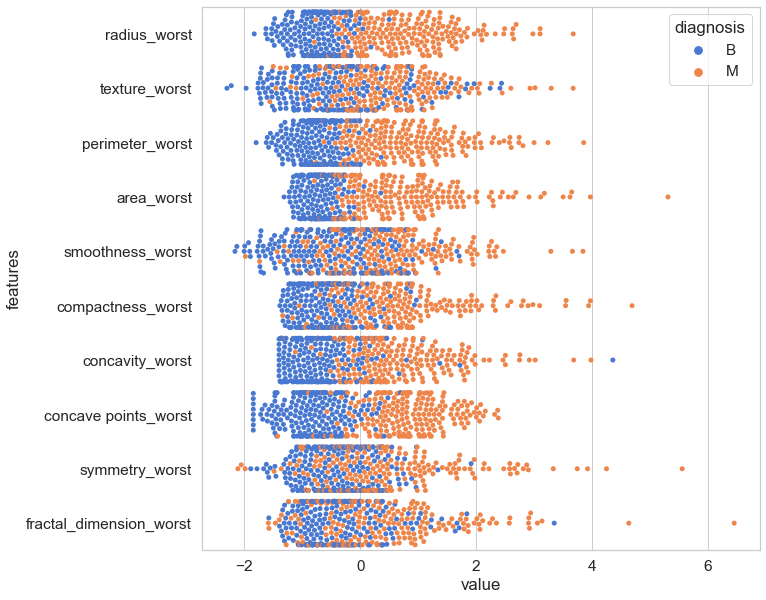

In [18]:
# Third ten features
data = pd.concat([y,x_scaled.iloc[:,20:30]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="diagnosis", data=data,split=True, inner="quart")
# plt.xticks(rotation=90)


data = pd.concat([y,x_scaled.iloc[:,20:31]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="value", y="features", hue="diagnosis", data=data)
toc = time.time()
# plt.xticks(rotation=90)

* Then the correlation between the characteristics should be investigated, in order to find if there is any kind of relationship between them.

* A common way of measuring correlation is the Pearson correlation coefficient. This coefficient, denoted by $r$, is a value from $-1$ to $+1$.

* A value of $+1$ indicates that the variables have a perfect positive linear relationship, a value of $-1$ indicates a perfect negative linear relationship, while a value of $0$ indicates no linear correlation.

* Here for example, the pearson coefficient correlation between *concativity_worst* and *concave points_worst* is shown.

In [19]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
stats.pearsonr(x.loc[:,'concavity_worst'], x.loc[:,'concave points_worst'])

(0.8590890061753854, 8.022936566118456e-125)

In [20]:
stats.kendalltau(x.loc[:,'concavity_worst'], x.loc[:,'concave points_worst'])

KendalltauResult(correlation=0.7370124111069243, pvalue=1.1761645921866563e-113)

In [21]:
stats.spearmanr(x.loc[:,'concavity_worst'], x.loc[:,'concave points_worst'])

SpearmanrResult(correlation=0.9091684938816447, pvalue=1.1918206997301482e-162)

Text(-100, 0.46, 'p = 3.76e-164')

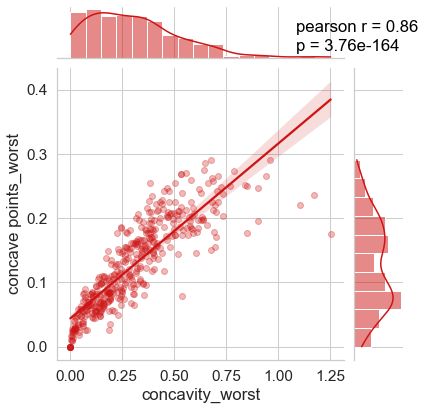

In [22]:
# sns.set(style="whitegrid",palette="muted",font_scale = 1)
sns.jointplot(x.loc[:,'concavity_worst'], x.loc[:,'concave points_worst'], kind="reg", color="#ce1414",scatter_kws={'alpha':0.3})
# add text annotation
plt.text(-100, 0.49, "pearson r = 0.86", horizontalalignment='left', size='medium', color='black')
plt.text(-100, 0.46, "p = 3.76e-164", horizontalalignment='left', size='medium', color='black')

* To observe the correlation between all features, heat map will be used.

* Those features that are higly correlated with each other (*value > 0.8*), can be removed because they are not useful for classification. Besides, they are going to consume computing resources from training the machine learning models.

Text(0.5, 1.0, 'Correlation Map')

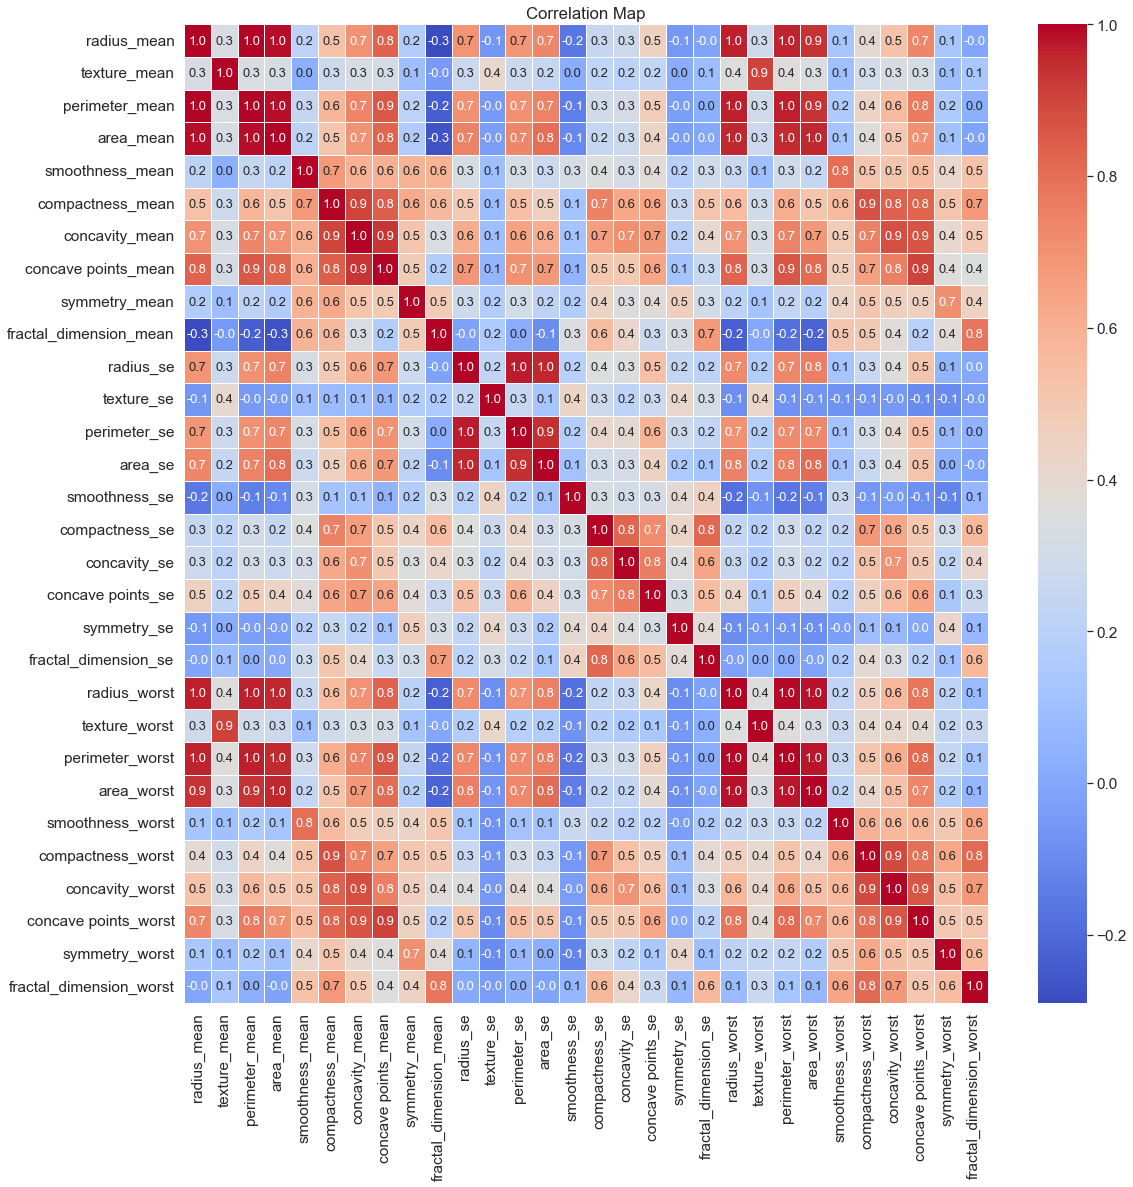

In [23]:
#correlation map
sns.set(font_scale = 1.4)
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x_scaled.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 13})
plt.title('Correlation Map')

In [119]:
# *** Functions for Mutual Information (score and plot) ***
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=13)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#:~:text=Mutual%20information%20(MI)%20%5B1,higher%20values%20mean%20higher%20dependency.
# https://www.kaggle.com/code/ryanholbrook/mutual-information/tutorial
# https://www.kaggle.com/code/palazar/exercise-mutual-information/edit

<!-- * Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. -->

* Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.
<!-- 
- Mutual information is a great general-purpose metric and especially useful at the start of feature development when someone might not know what model to use yet. It is:

    1. easy to use and interpret,
    2. computationally efficient,
    3. theoretically well-founded,
    4. resistant to overfitting, and,
    5. able to detect any kind of relationship -->

* The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

concave points_mean        0.494677
perimeter_worst            0.489851
radius_worst               0.474113
concave points_worst       0.473548
area_worst                 0.465635
perimeter_mean             0.413793
concavity_mean             0.409739
radius_mean                0.382497
concavity_worst            0.373997
area_mean                  0.364609
area_se                    0.342532
compactness_mean           0.281201
compactness_worst          0.279553
radius_se                  0.249217
perimeter_se               0.248510
concavity_se               0.160605
concave points_se          0.155886
texture_worst              0.141442
smoothness_worst           0.120339
texture_mean               0.106721
fractal_dimension_worst    0.102641
smoothness_mean            0.093758
symmetry_worst             0.083928
compactness_se             0.068612
symmetry_mean              0.063144
fractal_dimension_se       0.025640
fractal_dimension_mean     0.017193
texture_se                 0

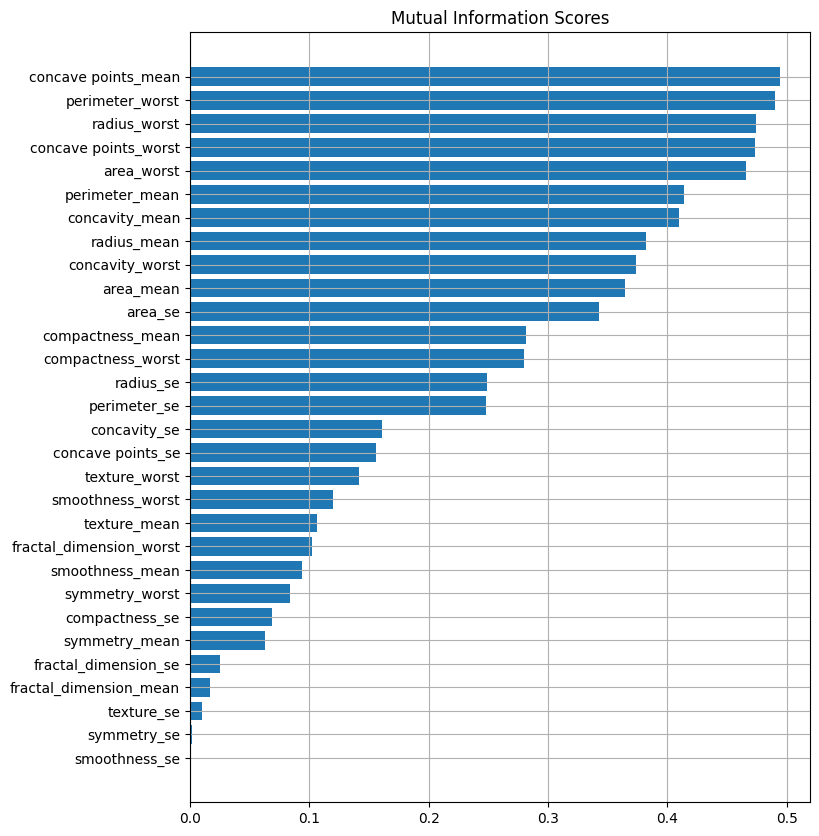

In [26]:
mi_scores = make_mi_scores(x_scaled, y)
print(mi_scores.head(30))
# print(mi_scores.tail(20))  # uncomment to see bottom 20
plt.style.use('default')
plt.figure(dpi=100, figsize=(8, 10))
plt.grid()
plot_mi_scores(mi_scores.head(30))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

- Here are some things to consider when applying mutual information:

    1. MI can help to understand the relative potential of a feature as a predictor of the target, considered by itself.
    2. It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
    3. The actual usefulness of a feature depends on the model with which it will be used. A feature is only useful to the extent that its relationship with the target is one the model can learn. Just because a feature has a high MI score doesn't mean the model will be able to do anything with that information. The feature may need to be transformed first to expose the association.

In [27]:
target_names=['Benign','Malignant']

* The procedure to do is in each validation to generate training data and test data, train `StandardScaler` on training data *only*, apply to both training data and test data, and do the training of the classifier and then its evaluation.

* In order to do everything correctly and in order, the *pipeline* feature offered by scikit-learn will be used.

In [28]:
# *** Function for classification report and set Cross validation iterator ***
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratified+k+fold
cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

## function for classification report in cross validation (with all predictions combined)
def classification_report_with_accuracy_score(y_true, y_pred):
  originalclass.extend(y_true)
  predictedclass.extend(y_pred)
  #print(classification_report(y_true, y_pred, target_names=target_names)) 
  return accuracy_score(y_true, y_pred) 

In [29]:
# Cross validate WITH ALL FEATURES
clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

originalclass = []
predictedclass = []

score = cross_val_score(clf, x, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
report = (classification_report(originalclass, predictedclass, target_names=target_names, digits=3)) # , output_dict=True
print(report)
# report_0 = pd.DataFrame(report).transpose()
# report_0

              precision    recall  f1-score   support

      Benign      0.958     0.958     0.958       212
   Malignant      0.958     0.958     0.958       212

    accuracy                          0.958       424
   macro avg      0.958     0.958     0.958       424
weighted avg      0.958     0.958     0.958       424



* The $F_1$ metric combines precision and recall.

* Mathematically, it is the *harmonious mean* of precision and recall.

* The harmonic mean of $n$ numbers $x_1, x_2, \ldots, x_n$ is defined as:

$$H={\frac {n}{{\frac {1}{x_{1}}}+{\frac {1}{x_{2}}}+\cdots +{\frac {1}{x_{n}}}}}$$

* Thus, the $F_1$ metric is:

$$F_{1}=2\cdot \frac{1}{\tfrac{1}{\mathrm{precision}}+\tfrac{1}{\mathrm{recall}}} = 2\cdot {\frac{ \mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} +\mathrm{recall}}}$$

* The $F_1$ metric will be used instead of the simple mean because it penalizes outliers.

* If either recall or precision is zero, the $F_1$ metric will be zero.

In [30]:
# *** print f1 score mean and std ***
# scores = cross_val_score(clf, x_scaled, y, cv=5,scoring='f1_macro')
# scores
# print("F1 score is %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

<a id='5'></a>
## Feature Selection and Random Forest Classification

1. https://machinelearningmastery.com/an-introduction-to-feature-selection/
2. https://stats.stackexchange.com/questions/40576/is-using-the-same-data-for-feature-selection-and-cross-validation-biased-or-not
3. https://stats.stackexchange.com/questions/2306/feature-selection-for-final-model-when-performing-cross-validation-in-machine
4. https://stats.stackexchange.com/questions/27750/feature-selection-and-cross-validation
5. https://stats.stackexchange.com/questions/64825/should-feature-selection-be-performed-only-on-training-data-or-all-data
6. https://stackoverflow.com/questions/56308116/should-feature-selection-be-done-before-train-test-split-or-after
7. https://gijopeter.medium.com/cross-validation-for-ml-feature-selection-ffdb71e5a68f
8. https://insightsimaging.springeropen.com/articles/10.1186/s13244-021-01115-1
9. https://github.com/aydindemircioglu/radCV/blob/main/startExperiment.py

* In this part the features are selected by different methods. *Random forest classification* will be used for evaluation using the cross validation method with 10-folds.

<a id='6'></a>
### 1) Feature Selection by Correlation

* Features with a correlation greater than 0.8 are removed.

In [31]:
# # Create correlation matrix. Method 1 (simpler)
# corr_matrix = x_scaled.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.8
# correlated_features = [column for column in upper.columns if any(upper[column] > 0.8)]
# x_1=x_scaled.drop(correlated_features, axis=1)
# x_correlated_features = x_scaled[correlated_features]
# print("Correlated features over 0.8 : ",correlated_features)

In [116]:
#  *** Functions to drop correlated features ***
def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop 
    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop

def corrX(df, cut = 0.8) : # https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6
       
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    
    return(dropcols_names)

In [120]:
drop_new = corrX(x, cut = 0.8)
x_selected = x.drop(drop_new, axis=1)
print("Correlated features over 0.8 : ",len(drop_new),drop_new)
# list(set(x_correlated_features).difference(set(drop_new)))

Correlated features over 0.8 :  15 ['area_worst', 'concave points_mean', 'perimeter_se', 'radius_mean', 'compactness_se', 'smoothness_mean', 'radius_se', 'texture_worst', 'compactness_worst', 'radius_worst', 'perimeter_worst', 'perimeter_mean', 'concavity_mean', 'concave points_worst', 'compactness_mean']


Text(0.5, 1.0, 'Correlation Map')

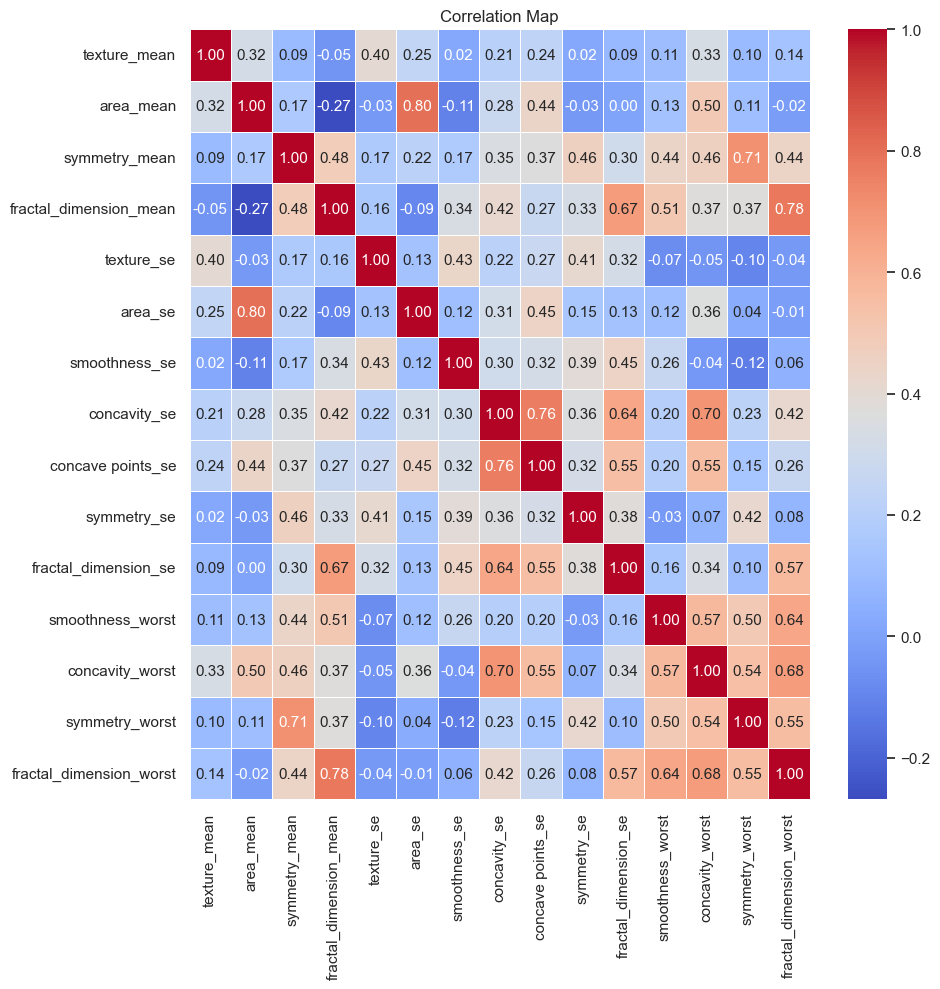

In [35]:
sns.set(font_scale = 1)
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(x_selected.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 11})
plt.title('Correlation Map')

concavity_worst            0.376438
area_mean                  0.368126
area_se                    0.341920
concavity_se               0.160568
concave points_se          0.157428
smoothness_worst           0.119311
texture_mean               0.106583
fractal_dimension_worst    0.099809
symmetry_worst             0.080678
symmetry_mean              0.059284
fractal_dimension_se       0.026315
fractal_dimension_mean     0.018848
texture_se                 0.009281
smoothness_se              0.000000
symmetry_se                0.000000
Name: MI Scores, dtype: float64


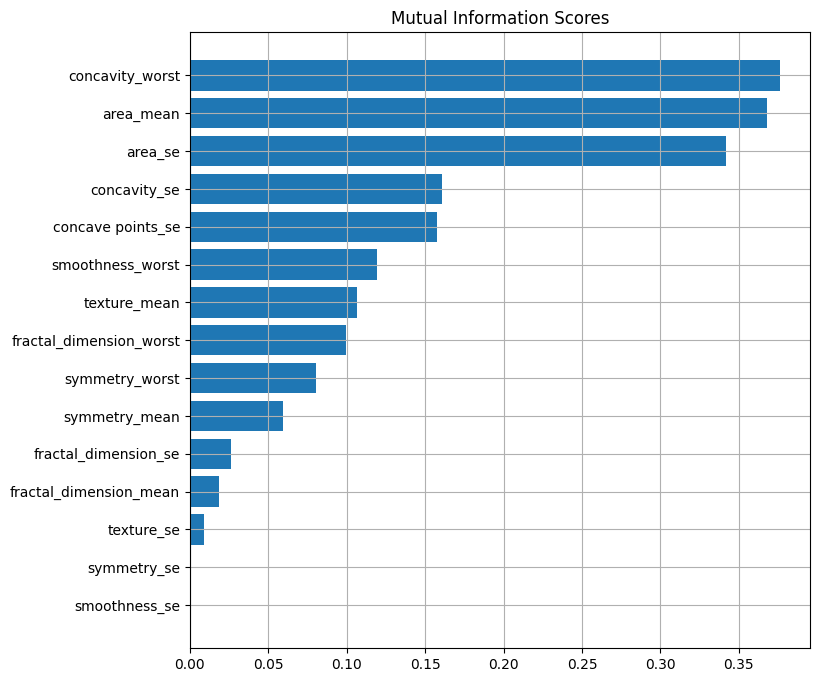

In [112]:
mi_scores = make_mi_scores(x_selected, y)
print(mi_scores)
plt.style.use('default')
plt.figure(dpi=100, figsize=(8, 8))
plt.grid()
plot_mi_scores(mi_scores)

In [36]:
originalclass = []
predictedclass = []
  
# Cross validate Without correlated features
clf_1 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

score = cross_val_score(clf_1, x_selected, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.963     0.976     0.970       212
   Malignant      0.976     0.962     0.969       212

    accuracy                          0.969       424
   macro avg      0.969     0.969     0.969       424
weighted avg      0.969     0.969     0.969       424



<a id='7'></a>
### 2) [Univariate feature selection (SelectKbest)](<http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest>)

* In univariate feature selection, sklearn's SelectKBest will be used which removes all but the k highest-scoring features.

* In this method the number of features to be used must be selected. For example, k (number of features) will be 5 or 10 or 15 and so on. Exhaustive search (GridSearchCV) will be used to find the optimal number of k.

In [37]:
# https://www.yourdatateacher.com/2021/04/26/feature-selection-via-grid-search-in-supervised-models/

pipeline = Pipeline([('scaler', StandardScaler()),('selector',SelectKBest(f_classif)),('model',RandomForestClassifier(random_state = 13))])

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {
  'selector__k': list(range(1, 15))
#  , 'model__n_estimators':np.arange(10,200,10)   
 },
    n_jobs=-1,
    scoring="f1_macro",
    cv=cv,
    verbose=0
)
search.fit(x_selected,y)
search.best_params_

{'selector__k': 12}

In [38]:
# find best scored 12 features
select_feature = SelectKBest(f_classif, k=12).fit(x_selected, y)

# Get columns to keep and create new dataframe with those only
cols = select_feature.get_support(indices=True)
x_kbest = x_selected.iloc[:,cols]

In [39]:
# print('Score list:', select_feature.scores_)
# print('Feature list:', x_selected.columns)
print('Selected feature list:', x_kbest.columns)

Selected feature list: Index(['texture_mean', 'area_mean', 'symmetry_mean', 'area_se',
       'smoothness_se', 'concavity_se', 'concave points_se',
       'fractal_dimension_se', 'smoothness_worst', 'concavity_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


* The best 12 features are **'texture_mean', 'area_mean', 'symmetry_mean', 'area_se','smoothness_se', 'concavity_se', 'concave points_se','fractal_dimension_se', 'smoothness_worst', 'concavity_worst','symmetry_worst', 'fractal_dimension_worst'**. Now only these 9 features will be used for testing.

In [40]:
originalclass = []
predictedclass = []
  
# Cross validate SELECT K BEST
clf_2 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

score = cross_val_score(clf_2, x_kbest, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv) # cross val(search, x_selected)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.958     0.972     0.965       212
   Malignant      0.971     0.958     0.964       212

    accuracy                          0.965       424
   macro avg      0.965     0.965     0.965       424
weighted avg      0.965     0.965     0.965       424



<a id='8'></a>
### 3) [Recursive Feature Elimination (RFE)](<http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html>)

In [41]:
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier(random_state=13)      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=8, step=1) # tried 3 to 13 features and found that 8 was the best
rfe = rfe.fit(x_selected, y)

In [42]:
print('Chosen best 8 feature by rfe:',x_selected.columns[rfe.support_])

Chosen best 8 feature by rfe: Index(['texture_mean', 'area_mean', 'area_se', 'concavity_se',
       'concave points_se', 'smoothness_worst', 'concavity_worst',
       'symmetry_worst'],
      dtype='object')


* The 6 best features selected by `RFE` are **'area_mean', 'area_se', 'concavity_se', 'concave points_se', 'smoothness_worst', 'concavity_worst'**.

In [43]:
x_rfe = rfe.transform(x_selected)
#x_test_4 = rfecv.transform(x_test)
#random forest classifier with n_estimators=100 (default)
# clr_rf_3 = clf_rf_3.fit(x_rfe,y)

originalclass = []
predictedclass = []
  
# Cross validate RFE
clf_3 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

score = cross_val_score(clf_3, x_rfe, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.962     0.967     0.965       212
   Malignant      0.967     0.962     0.965       212

    accuracy                          0.965       424
   macro avg      0.965     0.965     0.965       424
weighted avg      0.965     0.965     0.965       424



<a id='9'></a>
### 4) [Recursive Feature Elimination with Cross-Validation (RFECV)](<http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html>)

* Now in addition to the best features the number of them will also be found.

In [44]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier(random_state=13)
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=clf_rf_4,min_features_to_select=min_features_to_select, step=1, cv=cv,scoring='f1_macro')
rfecv = rfecv.fit(x_selected, y)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_selected.columns[rfecv.support_])

Optimal number of features : 15
Best features : Index(['texture_mean', 'area_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'texture_se', 'area_se', 'smoothness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')


In [45]:
x_rfecv = rfecv.transform(x_selected)
# #x_test_4 = rfecv.transform(x_test)
# #random forest classifier with n_estimators=100 (default)
# clr_rf_4 = clf_rf_4.fit(x_rfecv,y)

originalclass = []
predictedclass = []
  
# Cross validate RFECV
clf_4 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

score = cross_val_score(clf_4, x_rfecv, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.963     0.976     0.970       212
   Malignant      0.976     0.962     0.969       212

    accuracy                          0.969       424
   macro avg      0.969     0.969     0.969       424
weighted avg      0.969     0.969     0.969       424



Optimal number of features : 15


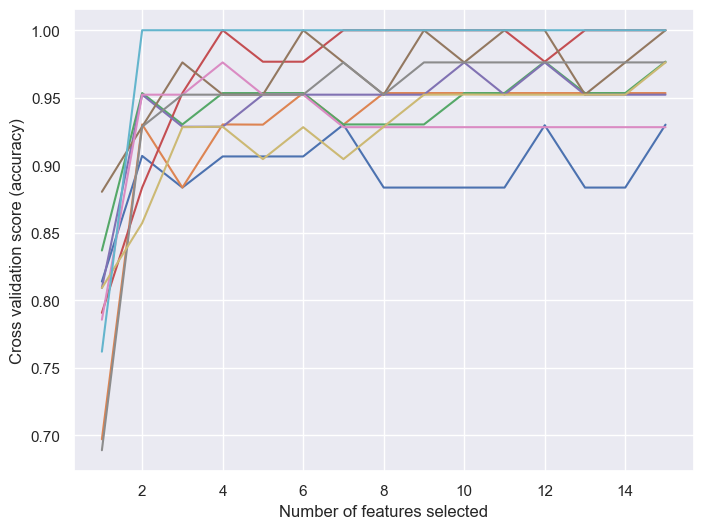

In [46]:
# Plot number of features VS. cross-validation scores
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

<a id='10'></a>
### 5) [Feature importances with a forest of trees](<https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html>)

* In the random forest classification method there is an attribute **feature_importances_** which is the importance of the features (the higher, the more important the feature). *!!! To use the feature_importance method, there should be no corellated features in the training data. The random forest selects randomly in each iteration, so the order of the feature importance list may change.*

Feature ranking:
1. feature 1 (0.215659)
2. feature 12 (0.212876)
3. feature 5 (0.170618)
4. feature 7 (0.066184)
5. feature 11 (0.063618)
6. feature 13 (0.053812)
7. feature 0 (0.046325)
8. feature 8 (0.043705)
9. feature 14 (0.027160)
10. feature 3 (0.024271)
11. feature 2 (0.021247)
12. feature 9 (0.015126)
13. feature 6 (0.013354)
14. feature 10 (0.013060)
15. feature 4 (0.012985)


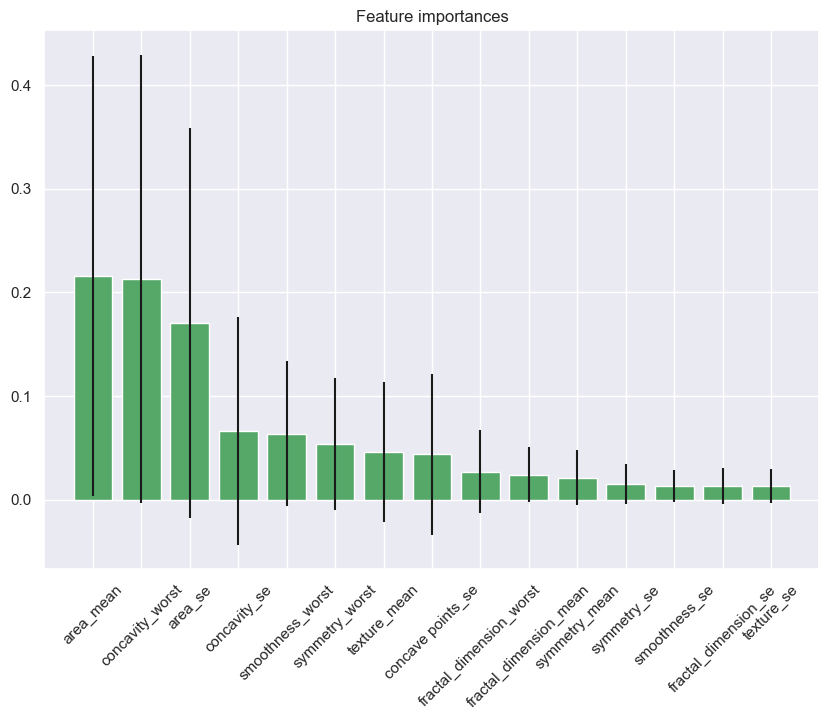

In [47]:
clf_rf_5 = RandomForestClassifier(random_state=13)      
clr_rf_5 = clf_rf_5.fit(x_selected,y)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_selected.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(x_selected.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_selected.shape[1]), x_selected.columns[indices],rotation=45)
plt.xlim([-1, x_selected.shape[1]])
plt.show()

In [48]:
x_5 = x_selected[['area_mean','concavity_worst','area_se','concavity_se','smoothness_worst','symmetry_worst','texture_mean','concave points_se']]

originalclass = []
predictedclass = []
  
# Cross validate Random forest feature importances
clf_5 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

score = cross_val_score(clf_5, x_5, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.963     0.972     0.967       212
   Malignant      0.971     0.962     0.967       212

    accuracy                          0.967       424
   macro avg      0.967     0.967     0.967       424
weighted avg      0.967     0.967     0.967       424



<a id='11'></a>
### 6) [XGBoost Feature importances](<https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/>)

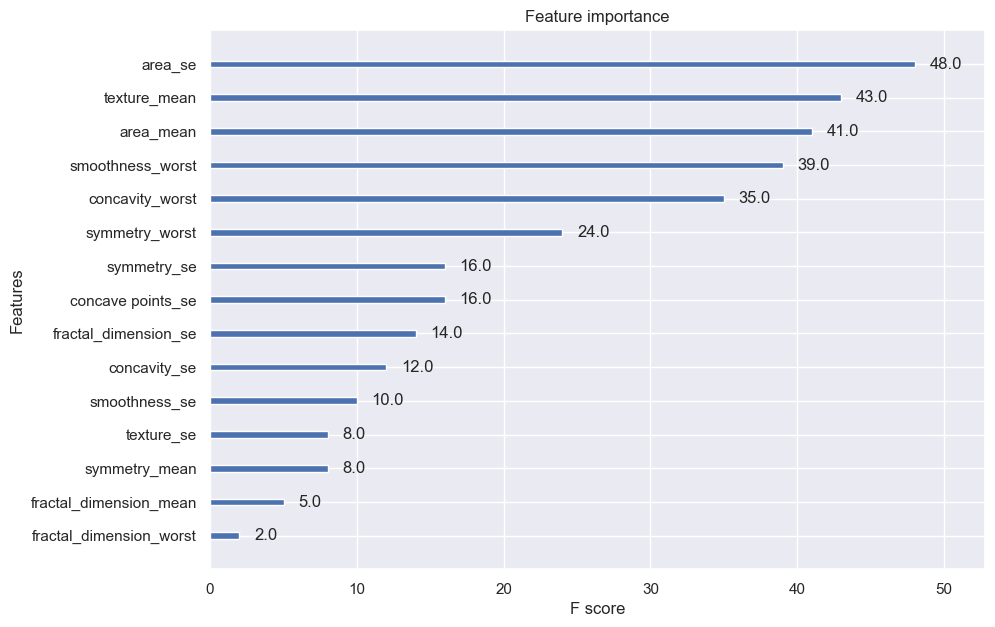

In [49]:
le= LabelEncoder()
le.fit(y)
y_le = le.transform(y)
# fit model no training data
model = XGBClassifier()
model.fit(x_selected, y_le)
# plot feature importance\
plt.rcParams["figure.figsize"] = (10, 7)
plot_importance(model)
plt.show()

In [50]:
x_6 = x_selected[['area_se','texture_mean','area_mean','smoothness_worst','concavity_worst','symmetry_worst','symmetry_se','concave points_se']]

originalclass = []
predictedclass = []
  
# Cross validate XGBoost feature importances
clf_6 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

score = cross_val_score(clf_6, x_6, y, scoring=make_scorer(classification_report_with_accuracy_score), cv = cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.967     0.958     0.962       212
   Malignant      0.958     0.967     0.962       212

    accuracy                          0.962       424
   macro avg      0.962     0.962     0.962       424
weighted avg      0.962     0.962     0.962       424



<a id='12'></a>
### 7) [Minimum Redundancy & Maximum Relevance](<https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b>)

In [51]:
from mrmr import mrmr_classif
y_mrmr = pd.Series(y)
selected_features = mrmr_classif(x_selected, y_mrmr, K=10) # tried K=3 to K=13 and fount that 11 was best
selected_features

100%|██████████| 10/10 [00:00<00:00, 87.13it/s]


['area_mean',
 'fractal_dimension_worst',
 'concavity_worst',
 'area_se',
 'smoothness_worst',
 'texture_mean',
 'concave points_se',
 'symmetry_worst',
 'symmetry_mean',
 'concavity_se']

In [52]:
x_mrmr = x[selected_features]

In [53]:
# sns.set(font_scale = 1.4)
# f,ax = plt.subplots(figsize=(16, 16))
# sns.heatmap(x_mrmr.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
# plt.title('Correlation Map')

In [54]:
originalclass = []
predictedclass = []
  
# Cross validate MRMR
clf_rf_mrmr = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

score = cross_val_score(clf_rf_mrmr, x_mrmr, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.958     0.967     0.962       212
   Malignant      0.967     0.958     0.962       212

    accuracy                          0.962       424
   macro avg      0.962     0.962     0.962       424
weighted avg      0.962     0.962     0.962       424



<a id='11'></a>
## [Feature extraction with PCA](<http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>)

In [55]:
def apply_pca(X, n_components ,standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [98]:
def plot_variance(pca, width=13, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=100)
    return axs

In [83]:
pca_30, X_pca_30, loadings_30 = apply_pca(x,30)
#loadings_30

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

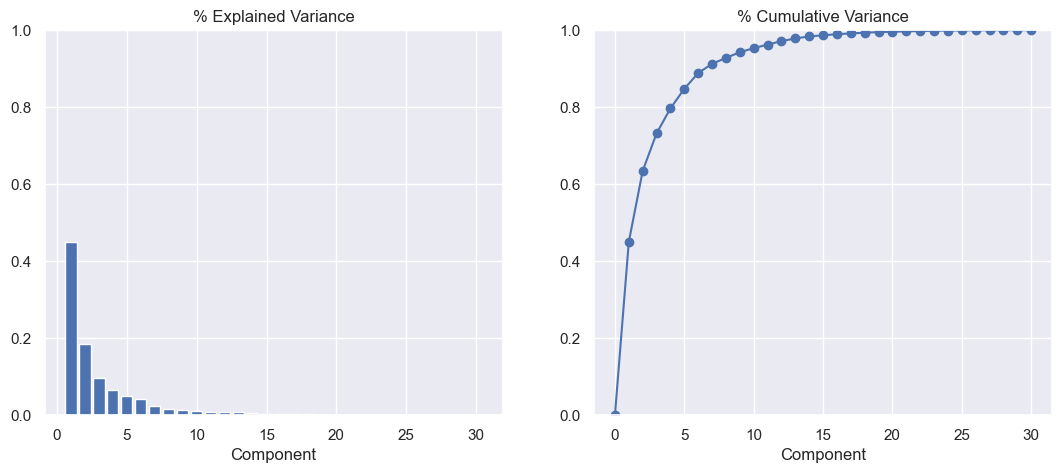

In [102]:
plot_variance(pca_30)

Text(0.5, 1.0, 'Correlation Map')

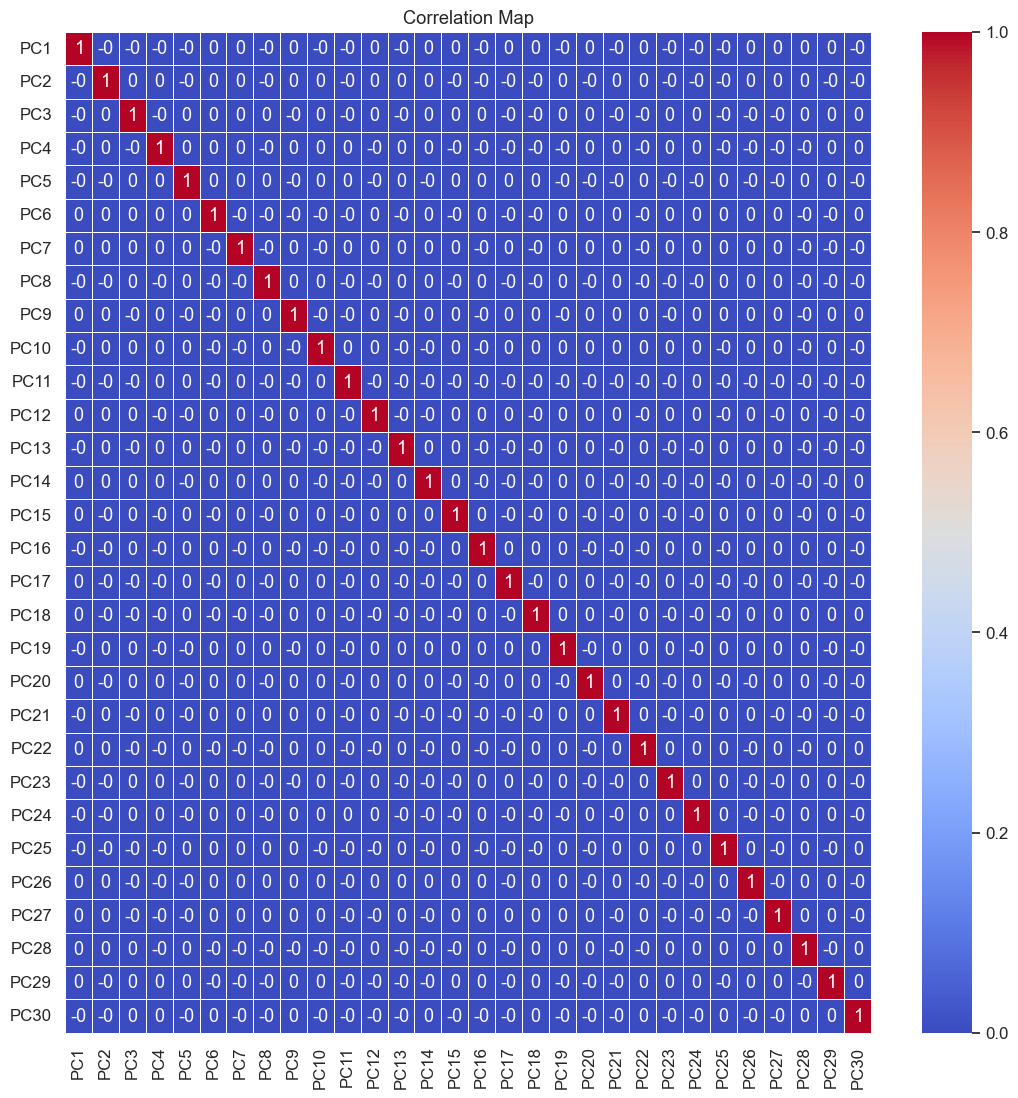

In [108]:
#correlation map
sns.set(font_scale = 1.1)
f,ax = plt.subplots(figsize=(13, 13))
sns.heatmap(X_pca_30.corr(), annot=True, linewidths=.5, fmt= '.0f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 13})
plt.title('Correlation Map')

PC1     0.501065
PC2     0.080977
PC30    0.078918
PC28    0.078411
PC13    0.075116
PC11    0.071497
PC27    0.062960
PC3     0.062003
PC26    0.059658
PC29    0.055534
PC21    0.054593
PC19    0.051203
PC18    0.045892
PC17    0.043252
PC25    0.041682
PC23    0.039918
PC14    0.027969
PC24    0.026728
PC22    0.023879
PC9     0.023742
PC15    0.023299
PC4     0.016112
PC16    0.014356
PC5     0.003411
PC6     0.001702
PC20    0.000000
PC12    0.000000
PC10    0.000000
PC8     0.000000
PC7     0.000000
Name: MI Scores, dtype: float64


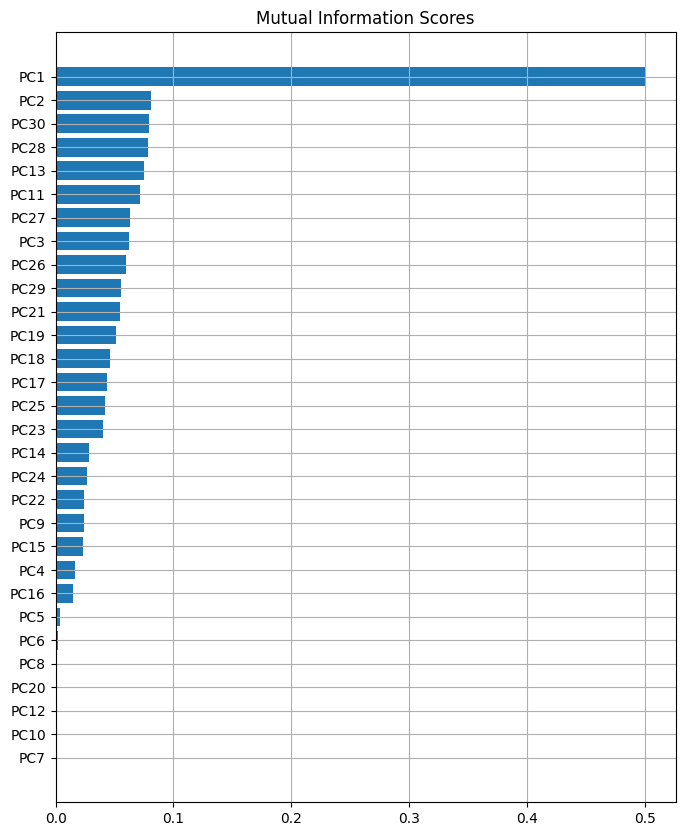

In [59]:
mi_scores = make_mi_scores(X_pca_30, y)
print(mi_scores.head(30))
plt.style.use('default')
plt.figure(dpi=100, figsize=(8, 10))
plt.grid()
plot_mi_scores(mi_scores.head(30))

- PCA components that have MI score = 0 
    - PC20
    - PC12
    - PC10
    - PC8
    - PC7

In [60]:
# https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

# *Principal Component Analysis* will be used to extract features. Before PCA, data should be normalized for better PCA performance.Exhaustive search (GridSearchCV) will be used to find the optimal number of *n components*.
# This approach may only benefit random forest and not the other ml methods that will be shown.

# # Define a pipeline to search for the best combination of PCA truncation and classifier regularization.
# pca = PCA()
# # Define a Standard Scaler to normalize inputs
# scaler = StandardScaler()
# # set the tolerance to a large value to make the example faster
# clf_pca = RandomForestClassifier(random_state=13)
# pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("clf_pca", clf_pca)])

# # X_digits, y_digits = datasets.load_digits(return_X_y=True)
# # Parameters of pipelines can be set using ‘__’ separated parameter names:
# param_grid = {
#     "pca__n_components": list(range(1,15))
# }
# search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cv)
# search.fit(x, y)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

# # Plot the PCA spectrum
# pca.fit(x_scaled)

# plt.figure(1, figsize=(14, 13))
# plt.plot(
#     np.arange(1, pca.n_components_ + 1), 1-pca.explained_variance_ratio_, linewidth=2
# )
# plt.ylabel("PCA explained variance ratio")

# plt.axvline(
#     search.best_estimator_.named_steps["pca"].n_components,
#     linestyle="dotted",
#     label="n_components chosen",
# );

* *Principal Component Analysis* will be used to extract features. Before PCA, data should be normalized for better PCA performance. Cumulative variance (%) with a threshhold of 95% will be used to find the optimal number of *n components*.

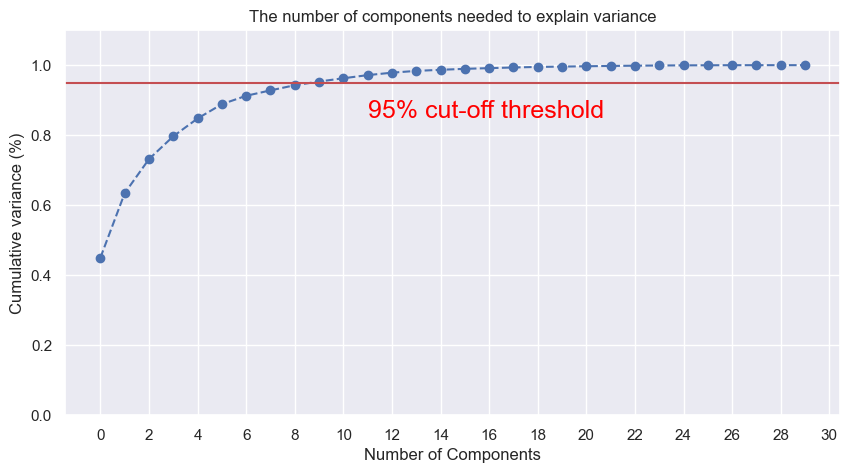

In [103]:
# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca = PCA().fit(x_scaled)

# % matplotlib inline
sns.set(font_scale = 1)
plt.rcParams["figure.figsize"] = (10,5)

fig, ax = plt.subplots()
xi = np.arange(0, 30, step=1)
y_pca= np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y_pca, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 31, step=2)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(11, 0.85, '95% cut-off threshold', color = 'red', fontsize=18)

ax.grid(axis='both')
plt.grid()
plt.show()

In [62]:
pca_10, X_pca_10, loadings_10 = apply_pca(x,10)

In [63]:
loadings_10

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
radius_mean,0.218518,-0.233725,-0.018139,0.028029,0.046488,0.034101,0.101316,0.078865,-0.234241,-0.035368
texture_mean,0.109728,-0.040626,0.041185,-0.606426,-0.057322,-0.030609,-0.018694,-0.115138,0.013932,0.243610
perimeter_mean,0.227198,-0.214113,-0.017035,0.030360,0.047296,0.031862,0.092418,0.090876,-0.220862,-0.043437
area_mean,0.218582,-0.236136,0.014282,0.044372,0.019129,0.007491,0.036744,0.021838,-0.219709,-0.071676
smoothness_mean,0.155321,0.184138,-0.082880,0.163659,-0.340301,-0.298490,0.130835,0.252891,0.082845,-0.146273
compactness_mean,0.240580,0.150512,-0.058289,0.037970,0.036795,0.009434,-0.047461,0.187294,-0.028733,-0.049521
concavity_mean,0.257412,0.051687,-0.008159,0.028490,0.067801,-0.020104,0.120749,0.065524,0.091185,-0.201321
concave points_mean,0.258823,-0.037871,-0.031897,0.064549,-0.037784,-0.048447,0.128503,0.204991,-0.051837,-0.077017
symmetry_mean,0.141802,0.192773,-0.029746,0.088134,-0.341460,0.319478,0.067275,0.290869,0.031474,0.561687
fractal_dimension_mean,0.067904,0.367600,-0.002415,0.075980,-0.028218,-0.132067,-0.308236,0.171084,-0.026433,-0.072906


In [64]:
print(pca_10.explained_variance_ratio_)
print(pca_10.explained_variance_ratio_.sum())

[0.45011867 0.18433661 0.0972821  0.06516722 0.05081468 0.04088532
 0.02395643 0.01542019 0.01471258 0.01058769]
0.9532814994802382


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

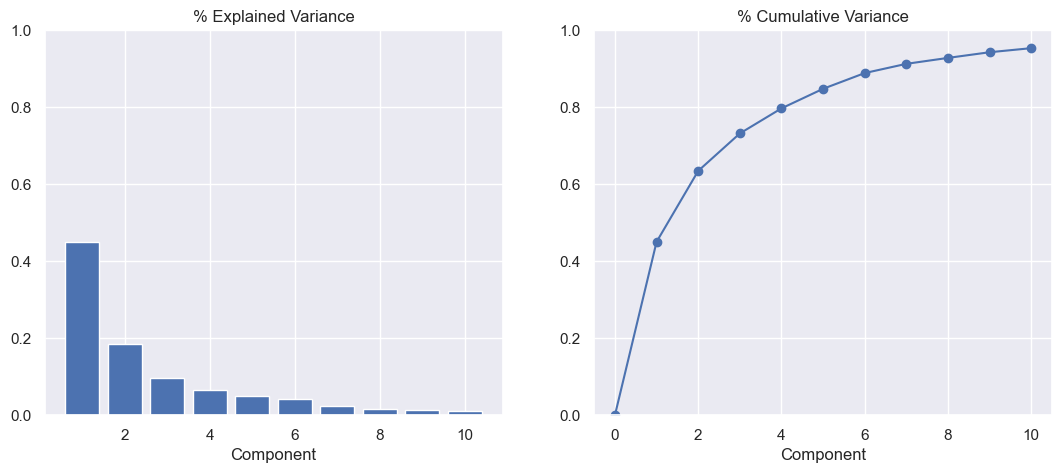

In [104]:
plot_variance(pca_10)

PC1     0.501065
PC2     0.080977
PC3     0.062003
PC9     0.023742
PC4     0.016112
PC5     0.003411
PC6     0.001702
PC7     0.000000
PC8     0.000000
PC10    0.000000
Name: MI Scores, dtype: float64


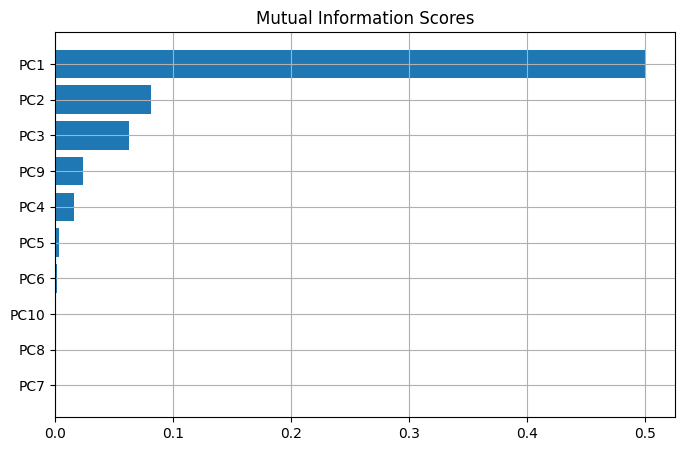

In [66]:
mi_scores = make_mi_scores(X_pca_10, y)
print(mi_scores.head(10))
plt.style.use('default')
plt.figure(dpi=100, figsize=(8, 5))
plt.grid()
plot_mi_scores(mi_scores.head(10))

In [67]:
originalclass = []
predictedclass = []
  
# Cross validate PCA
clf_rf_pca = make_pipeline(StandardScaler(),PCA(n_components=10), RandomForestClassifier(random_state=13))

score = cross_val_score(clf_rf_pca, x , y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.958     0.962     0.960       212
   Malignant      0.962     0.958     0.960       212

    accuracy                          0.960       424
   macro avg      0.960     0.960     0.960       424
weighted avg      0.960     0.960     0.960       424



<a id='12'></a>
## Summary

* As it turned out, it is possible to get the same or even better results with fewer features. Of course there are still many similar methods that were not used in this notebook.

* In general, it is good to use this feature selection or feature extraction process because it saves computing resources (this is mainly seen in large volumes of data) but also increases the performance of machine learning models.

*  Machine learning models will now be built for each of these feature selection or feature extraction methods.